# Wasserstein GAN in Pytorch - Faces

In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms, utils
from collections import deque
%matplotlib inline

First, we, set up batch size, image size, and size of noise vector:

In [2]:
bs,sz,nz = 512,64,100
PATH_G = 'model_g_faces'
PATH_D = 'model_d_faces'

In [3]:
PATH = '/home/m20163692/data/celeb/data/CelebA'

In [4]:
data = datasets.ImageFolder(PATH,
    transform=transforms.Compose([
        transforms.Scale(int(sz * 1.5)),
        transforms.CenterCrop(sz),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))

Even parallel processing is handling automatically by torch-vision.

In [5]:
dataloader = torch.utils.data.DataLoader(data, bs, True, num_workers=8)
n = len(dataloader); n

396

In [6]:
next(iter(dataloader))[0].size()

torch.Size([512, 3, 64, 64])

Our activation function will be `tanh`, so we need to do some processing to view the generated images.

In [7]:
def show(img, fs=(8,8)):
    plt.figure(figsize = fs)
    plt.imshow(np.transpose((img/2+0.5).clamp(0,1).numpy(), (1,2,0)), interpolation='nearest')
    plt.show()

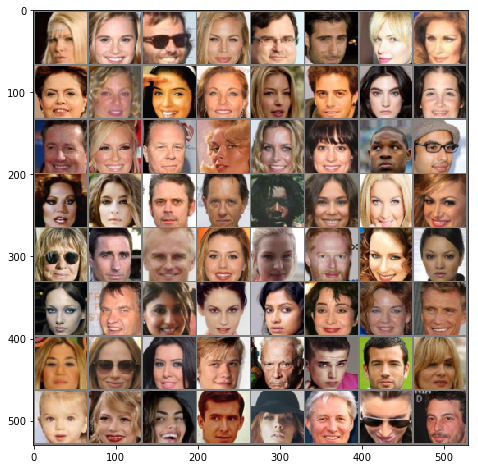

In [8]:
show(utils.make_grid(iter(dataloader).next()[0][:64]))

## Create model

The CNN definitions are a little big for a notebook, so we import them.

In [9]:
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from dcgan_3conv import DCGAN_D, DCGAN_G

Pytorch uses `module.apply()` for picking an initializer.

In [10]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)): 
        m.weight.data.normal_(0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [11]:
netG = DCGAN_G(sz, nz, 3, 64, 2, 1).cuda()
netG.apply(weights_init);

In [12]:
netD = DCGAN_D(sz, 3, 64, 2, 1).cuda()
netD.apply(weights_init);

Just some shortcuts to create tensors and variables.

In [13]:
from torch import FloatTensor as FT

def Var(*params):
    return Variable(FT(*params).cuda())

def create_noise(b): 
    return Variable(FT(b, nz, 1, 1).cuda().normal_(0, 1))

In [14]:
# Input placeholder
input = Var(bs, 3, sz, nz)
# Fixed noise used just for visualizing images when done
fixed_noise = create_noise(64)
# The numbers 0 and -1
one = torch.FloatTensor([1]).cuda()
mone = one * -1

An optimizer needs to be told what variables to optimize. A module automatically keeps track of its variables.

In [15]:
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-4)

One forward step and one backward step for D

In [16]:
def step_D(v, init_grad):
    err = netD(v)
    err.backward(init_grad)
    return err

In [17]:
def make_trainable(net, val): 
    for p in net.parameters(): p.requires_grad = val

In [18]:
def save_img(i):
    path = f'faces/epoch_{i}.jpg'
    fake = netG(fixed_noise).data.cpu()
    utils.save_image(fake, path)

In [19]:
def train(niter, first=True, img_n=0):
    netG.train()
    gen_iterations = 0
    save_flag = 1
    last_times = deque(maxlen=5)
    history = {'Loss_D': [], 'Loss_G': [], 'Loss_D_real': [], 'Loss_D_fake': []}
    
    for epoch in range(niter):
        t0 = time()
        data_iter = iter(dataloader)
        i = 0
        while i < n:
            make_trainable(netD, True)
            d_iters = (100 if first and (gen_iterations < 25) or gen_iterations % 500 == 0 
                       else 5)
            # d_iters = (100 if first and (gen_iterations < 25) or gen_iterations % 500 == 0 
            #            else 5)
            
            j = 0
            while j < d_iters and i < n:
                j += 1; i += 1
                print(f'{i:04}/{n:04} - G_iterations: {gen_iterations:04}', end='\r')
                for p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
                real = Variable(next(data_iter)[0].cuda())
                netD.zero_grad()
                errD_real = step_D(real, one)
                fake = netG(create_noise(real.size()[0]))
                input.data.resize_(real.size()).copy_(fake.data)
                errD_fake = step_D(input, mone)
                errD = errD_real - errD_fake
                # Improved:
                # errD = -(errD_real - errD_fake)
                optimizerD.step()

            make_trainable(netD, False)
            netG.zero_grad()
            errG = step_D(netG(create_noise(bs)), one)
            # Improved:
            # errG = -step_D(netG(create_noise(bs)), one)
            optimizerG.step()
            gen_iterations += 1
            
            if save_flag == -1:
                p_g = PATH_G + '_temp.pkl'
                p_d = PATH_D + '_temp.pkl'
            else:
                p_g = PATH_G + '.pkl'
                p_d = PATH_D + '.pkl'
            
            torch.save(netG.state_dict(), p_g)
            torch.save(netD.state_dict(), p_d)
            save_flag *= -1

        save_img(epoch + img_n)
        elapsed = time() - t0
        last_times.append(elapsed)
        eta = np.mean(elapsed) * (niter - epoch - 1)
        history['Loss_D'].append(errD.data[0])
        history['Loss_D_real'].append(errD_real.data[0])
        history['Loss_D_fake'].append(errD_fake.data[0])
        history['Loss_G'].append(errG.data[0])
        
        print('[%d/%d][%d/%d] Loss_D: %f Loss_G: %f L_D_real: %f L_D_fake %f (%.2fs) [ETA: %.2fs]' % (
            epoch, niter, gen_iterations, n,
            errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0], elapsed, eta))
        
    return history

In [ ]:
%%time
# h = train(20, True) # First run
h = train(20, False, 21)

[0/20][61/396] Loss_D: -1.039824 Loss_G: 0.608683 L_D_real: -0.541537 L_D_fake 0.498288 (689.43s) [ETA: 13099.16s]
[1/20][141/396] Loss_D: -0.744974 Loss_G: 0.348014 L_D_real: -0.221715 L_D_fake 0.523259 (723.23s) [ETA: 13018.18s]
[2/20][221/396] Loss_D: -0.966723 Loss_G: 0.426746 L_D_real: -0.400631 L_D_fake 0.566092 (723.45s) [ETA: 12298.73s]
[3/20][301/396] Loss_D: -0.709180 Loss_G: 0.649347 L_D_real: -0.578164 L_D_fake 0.131017 (723.02s) [ETA: 11568.34s]
[4/20][381/396] Loss_D: -0.974599 Loss_G: 0.460348 L_D_real: -0.420457 L_D_fake 0.554143 (723.81s) [ETA: 10857.13s]
[5/20][461/396] Loss_D: -0.929938 Loss_G: 0.351410 L_D_real: -0.364371 L_D_fake 0.565567 (723.23s) [ETA: 10125.16s]
[6/20][522/396] Loss_D: -0.996478 Loss_G: 0.549973 L_D_real: -0.495266 L_D_fake 0.501212 (688.88s) [ETA: 8955.39s]
[7/20][602/396] Loss_D: -0.932054 Loss_G: 0.612424 L_D_real: -0.539482 L_D_fake 0.392573 (723.50s) [ETA: 8681.98s]
[8/20][682/396] Loss_D: -0.765466 Loss_G: 0.466000 L_D_real: -0.306104 L_D_

In [28]:
# p_g = PATH_G + '.pkl'
# p_d = PATH_D + '.pkl'
# torch.save(netG.state_dict(), p_g)
# torch.save(netD.state_dict(), p_d)

## View

In [20]:
# LOAD
netG.load_state_dict(torch.load(PATH_G + '.pkl'))
netD.load_state_dict(torch.load(PATH_D + '.pkl'))

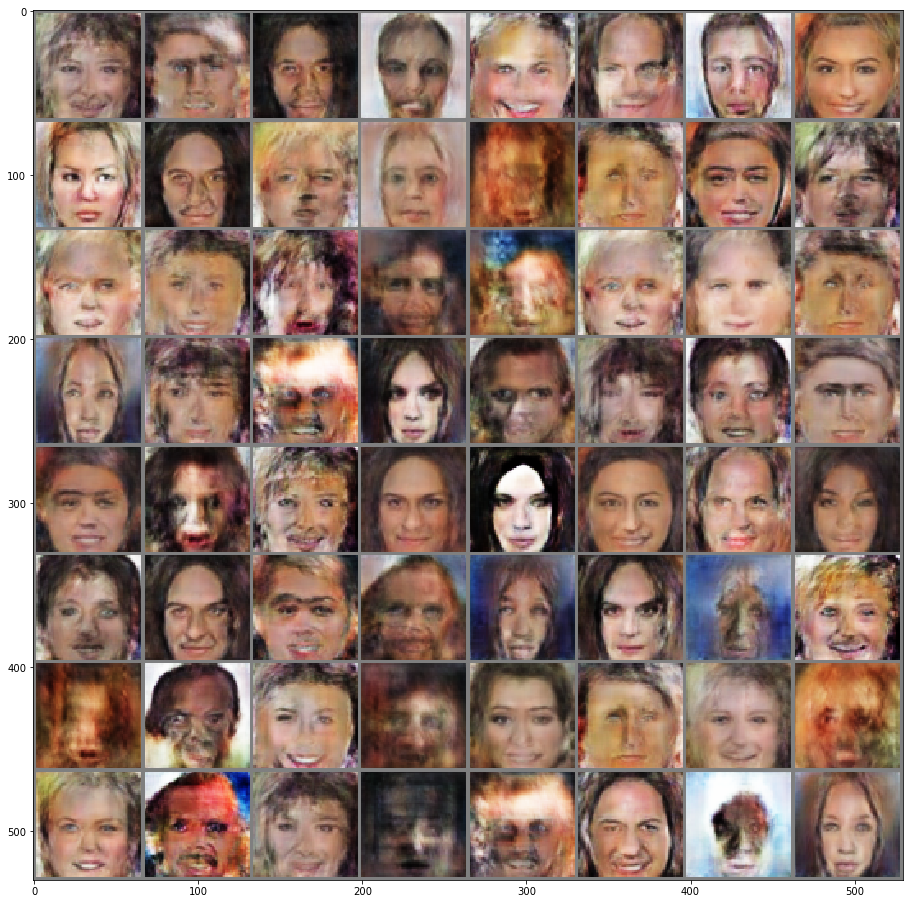

In [23]:
netG.eval()
fixed_noise = create_noise(64)
fake = netG(fixed_noise).data.cpu()
# show(random.choice(fake))
show(utils.make_grid(fake), (16,16))

## Check interpolation

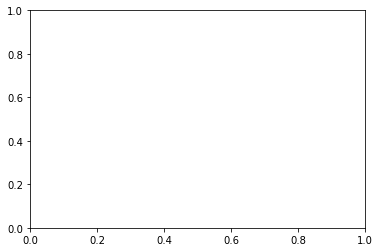

In [24]:
from IPython.display import HTML
from matplotlib import animation, rc

fig, ax = plt.subplots()

def animate(i):
    ax.imshow(np.transpose((interpolation[i]/2+0.5).clamp(0,1).numpy(), (1,2,0)), interpolation='nearest')

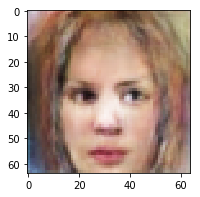

In [36]:
# get random image
noise_base = create_noise(1)
# noise_base = fixed_noise[-3:-2]
show(netG(noise_base).data.cpu()[0], (3,3))

In [45]:
n_imgs = 100
# noise = create_noise(1)
noise = noise_base.repeat(n_imgs,1,1,1)

# pick dimension
r_dim = random.randint(0, noise.size()[1] - 1)
print(f'choosen dim = {r_dim}')
noise[:,r_dim] = torch.linspace(-2, 2, n_imgs)

# get & show imgs
interpolation = netG(noise).data.cpu()

choosen dim = 97


In [47]:
# show(utils.make_grid(interpolation, nrow=int(np.sqrt(n_imgs))), (16,16))

In [48]:
anim = animation.FuncAnimation(fig, animate, frames=n_imgs, interval=100)
HTML(anim.to_html5_video())

In [128]:
import os
from PIL import Image

idxs = [int(f[6:-4]) for f in os.listdir('faces') if f[-3:] == 'jpg']
idxs.sort()

def animate_learning(i):
    path = f'faces/epoch_{i}.jpg'
    ax.imshow(Image.open(path))

In [130]:
anim = animation.FuncAnimation(fig, animate_learning, frames=len(idxs), interval=500)
HTML(anim.to_html5_video())